In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from properscoring import crps_ensemble
import random




sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SimulateSero, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SeroTrain, DirectTrain
from model_tools.models import SimSero, DirectSero
from model_tools.evaluation import eval_sero_pnn, plot_sero_pnn_preds, eval_pnn, eval_direct_sero

start_year = 2016
end_year = 2022
data_split = [5/7, 1/7, 1/7]
seed = 123

D = 40
M = 50
T = 40
Q = 40
N = 4


# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


In [2]:
# Simulate Data
# True counts * Constant sero prop vec * constant delay vec from average across world samples
sero_all = ["DENV-1", "DENV-2", "DENV-3", "DENV-4"]



delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df = delays_df.set_index("Collection date")
delays_df.index = pd.to_datetime(delays_df.index)

y_true = delays_df.sum(1)[:-2]
y_true_df = y_true.groupby(y_true.index.to_period("M")).sum()
month_dates = y_true.index.to_period("M")
month_dates = list(set(month_dates))
month_dates = sorted([d.to_timestamp() for d in month_dates])
y_true = np.array(y_true_df)
const = 10*np.ones_like(y_true)
L = len(const)

In [3]:

month_dates

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2012-02-01 00:00:00'),
 Timestamp('2012-03-01 00:00:00'),
 Timestamp('2012-04-01 00:00:00'),
 Timestamp('2012-05-01 00:00:00'),
 Timestamp('2012-06-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2012-08-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2012-10-01 00:00:00'),
 Timestamp('2012-11-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2013-02-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-08-01 00:00:00'),
 Timestamp('2013-09-01 00:00:00'),
 Timestamp('2013-10-01 00:00:00'),
 Timestamp('2013-11-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00'),
 Timestamp('2014-04-01 00:00:00'),
 Timestamp('2014-05-

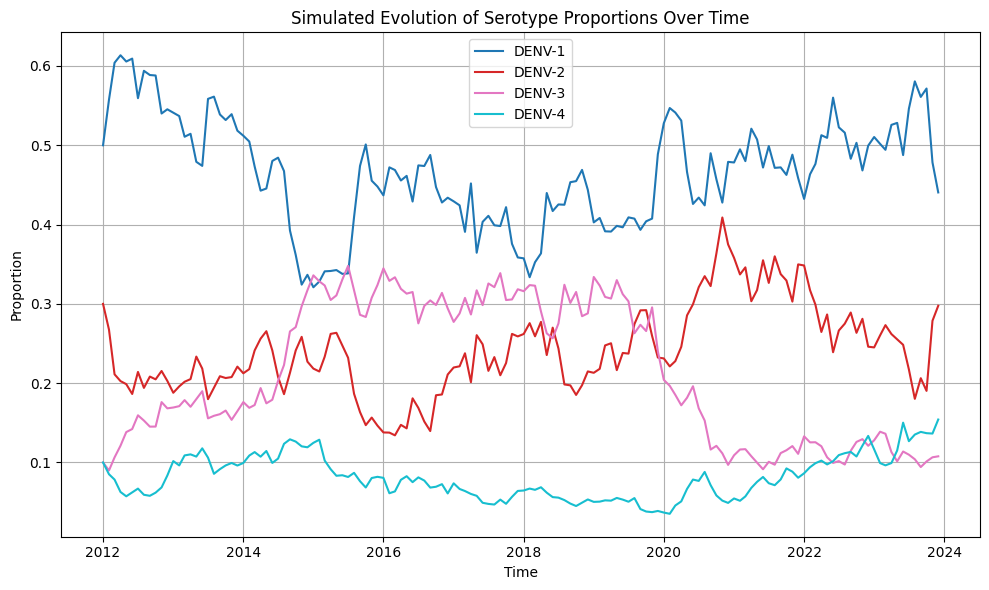

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S = 4    # number of serotypes
np.random.seed(1)  # for reproducibility


# Initialize p_sero array: shape (S, T, 1)

p_sero = np.zeros((S, L, 1))

# Set initial condition: uniform distribution
initial_weights = np.array([0.5, 0.3, 0.1, 0.1])
p_sero[:, 0, 0] = initial_weights / initial_weights.sum()

# Simulate over time

for t in range(1, L):
    # Add noise to the log of previous probabilities
    noise = np.random.normal(0, 0.1, S)
    logits = np.log(p_sero[:, t - 1, 0] + 1e-6) + noise  # add small epsilon to avoid log(0)

    # Apply softmax to get new probabilities
    exp_logits = np.exp(logits)
    p_sero[:, t, 0] = exp_logits / np.sum(exp_logits)

# Optional: plot the serotype proportions over time
plt.figure(figsize=(10, 6))
colors = ["#1f77b4", "#d62728", "#e377c2", "#17becf"]
for s in range(S):
    plt.plot(month_dates, p_sero[s, :, 0], label=f"DENV-{s + 1}", color=colors[s])
plt.title("Simulated Evolution of Serotype Proportions Over Time")
plt.xlabel("Time")
plt.ylabel("Proportion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
p_sero.shape

(4, 144, 1)

In [6]:
const.shape

(144,)

In [7]:


denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")

denv_df = denv_df[denv_df['Delay'] < 60]

# If your original denv_df dates are datetime
denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date'])

start_month = pd.to_datetime(delays_df.index.min())
end_month = pd.to_datetime(delays_df.index.max())

# Create a DataFrame of month start dates as datetime (not Period)
dates = pd.DataFrame({
    "Collection date": pd.date_range(start=start_month, end=end_month, freq='MS')
})

df = denv_df[denv_df['Sero'] == "DENV-1"] \
    .groupby(['Sero', 'Collection date', 'Delay']) \
    .size() \
    .reset_index(name='count')

df = df.pivot(index='Collection date', columns='Delay', values='count')

# Ensure df.index is datetime as well
df.index = pd.to_datetime(df.index)

p_delay = np.array(df.fillna(0).mean(0) / df.fillna(0).mean(0).sum())

const = const[np.newaxis, :, np.newaxis]  # shape (1,T,1)
p_delay = p_delay[np.newaxis, np.newaxis, :Q]  # shape (1,1,D)

# multiply to get (S,T,D)
sero_tensor = p_sero * const * p_delay
sero_tensor = sero_tensor.round()
for s,sero in enumerate(sero_all):
    sero_df = pd.DataFrame(sero_tensor[s, :, :])
    sero_df.index = y_true_df.index
    sero_df.to_csv(project_dir / "data" / "model" / "sero_dfs" / f"{sero}.csv", index=True)
    print("Saving sero: ", sero)

Saving sero:  DENV-1
Saving sero:  DENV-2
Saving sero:  DENV-3
Saving sero:  DENV-4


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_57456/2665813340.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date'])


In [8]:
sero_tensor.shape

(4, 144, 40)

In [9]:
print(p_delay.shape)

(1, 1, 40)


In [10]:
# Create Serotype obj
sero_tensor = []
base_folder = project_dir / "data" / "model" / "sero_dfs"
files = [f for f in os.listdir(base_folder) if f.endswith('.csv')]
for file in files:
    file_path = os.path.join(base_folder, file)
    df = pd.read_csv(file_path)
    dates = df['Collection date']
    sero_df = df.drop(columns="Collection date")
    sero_tensor.append(sero_df)
sero_tensor = np.array(sero_tensor)

sero_dataset = SimulateSero(sero_tensor, dates, T=T, Q=Q, N=N, prop_tensor=p_sero)

In [11]:
sero_dataset.get_prop_vec("2020-01-01").shape

(4, 1)

In [12]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)

In [13]:
class SeroPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, sero_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.sero_obj = sero_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        sero_obs = self.sero_obj.get_obs(date)
        prop_vec = self.sero_obj.get_prop_vec(date)
        y = self.true_count_obj.get_y_prop(date, prop_vec)
        dow = date.day_of_week
        return (obs, dow, sero_obs), y
    
set_seed(seed)
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")


train_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, train_dates)
val_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, val_dates)
test_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset,  sero_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_sero_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_sero_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_sero_pnn_dataset, batch_size=32, shuffle=False)


In [14]:
sero_tensor.shape

(4, 144, 40)

In [15]:
_, y = next(iter(train_sero_pnn_dataset))
y.shape

(4, 1)

In [16]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SimSero(M=M, D=D, T=T, Q=Q, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_train = SeroTrain("SeroPNN", lr=0.0003)
sero_pnn_train.train_model(sero_pnn_model, train_loader, val_loader)



Epoch 1 - Train loss: 2.24e+03 - Val loss: 2.67e+04 - ES count: 0
Epoch 2 - Train loss: 1.95e+03 - Val loss: 2.15e+04 - ES count: 0
Epoch 3 - Train loss: 1.79e+03 - Val loss: 2.08e+04 - ES count: 0
Epoch 4 - Train loss: 1.73e+03 - Val loss: 1.99e+04 - ES count: 0
Epoch 5 - Train loss: 1.57e+03 - Val loss: 1.57e+04 - ES count: 0
Epoch 6 - Train loss: 1.39e+03 - Val loss: 1.47e+04 - ES count: 0
Epoch 7 - Train loss: 1.27e+03 - Val loss: 1.32e+04 - ES count: 0
Epoch 8 - Train loss: 1.15e+03 - Val loss: 1.06e+04 - ES count: 0
Epoch 9 - Train loss: 1.04e+03 - Val loss: 1.26e+04 - ES count: 1
Epoch 10 - Train loss: 9.22e+02 - Val loss: 9.4e+03 - ES count: 0
Epoch 11 - Train loss: 8.16e+02 - Val loss: 8.84e+03 - ES count: 0
Epoch 12 - Train loss: 6.95e+02 - Val loss: 7.9e+03 - ES count: 0
Epoch 13 - Train loss: 6.15e+02 - Val loss: 6.86e+03 - ES count: 0
Epoch 14 - Train loss: 5.28e+02 - Val loss: 5.31e+03 - ES count: 0
Epoch 15 - Train loss: 4.47e+02 - Val loss: 4.42e+03 - ES count: 0
Epoch 

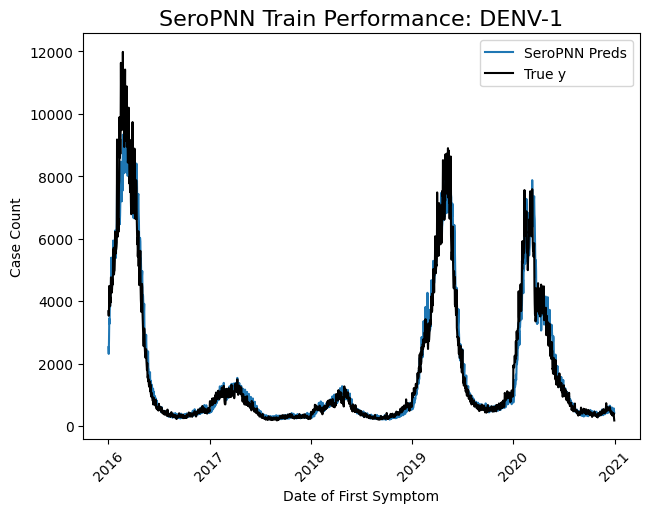

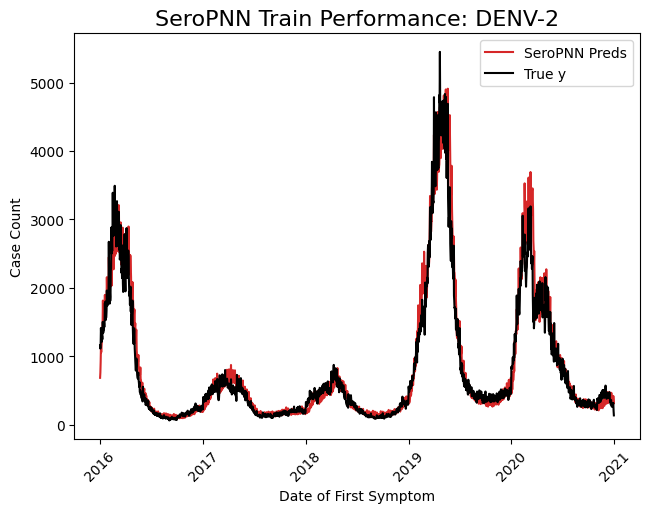

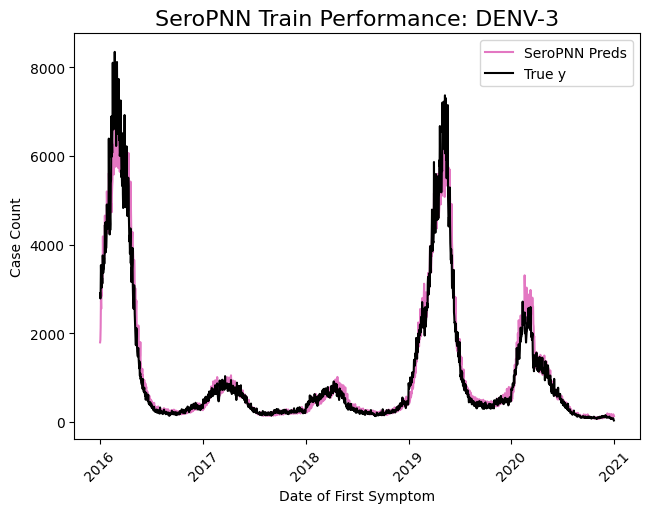

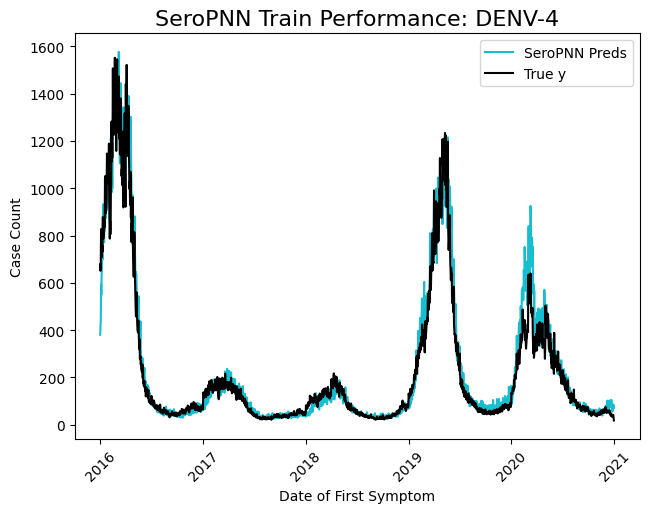

In [17]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SimSero(M=M, D=D, T=T, Q=Q, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SeroPNN"))

sero_pnn_train_samples, train_y_true = eval_sero_pnn(train_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_train_samples, train_sero_pnn_dataset, N, "SeroPNN Train Performance")

# crps = 0
# crps = sum([crps_ensemble(train_y_true[:,s], sero_pnn_train_samples[:,s,:]).mean() for s in range(N)])
# print(f"CRPS: {crps}")


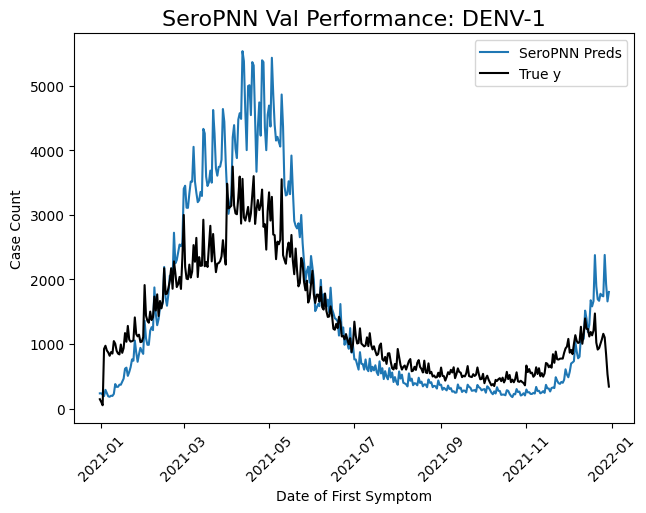

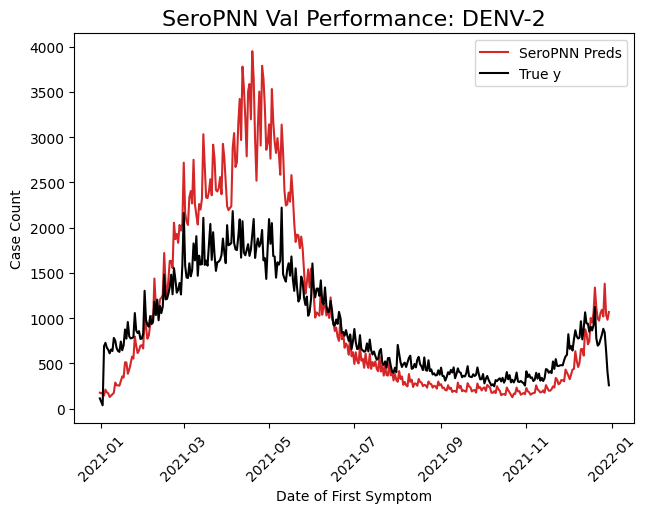

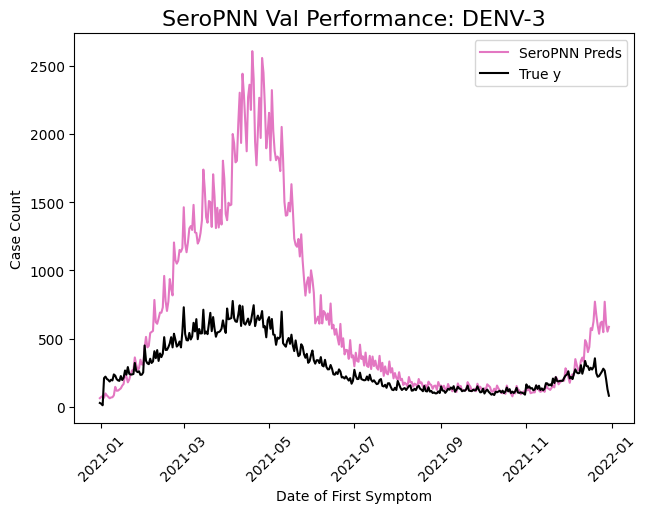

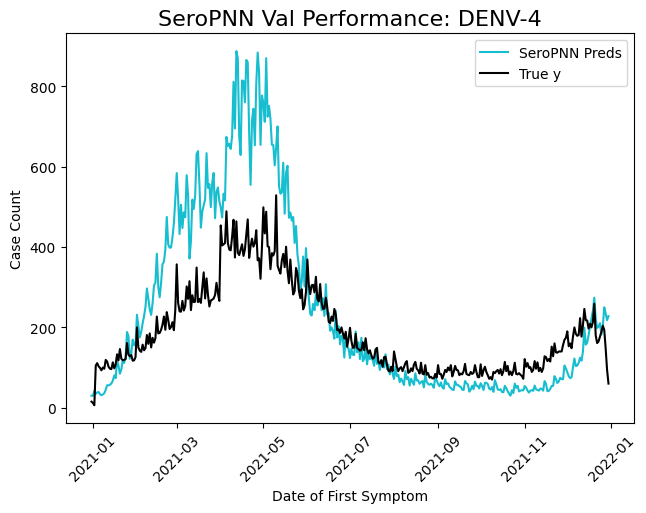

In [18]:
sero_pnn_val_samples, val_y_true = eval_sero_pnn(val_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_val_samples, val_sero_pnn_dataset, N, "SeroPNN Val Performance")

# crps = 0
# crps = sum([crps_ensemble(val_y_true[:,s], sero_pnn_val_samples[:,s,:]).mean() for s in range(N)])
# print(f"CRPS: {crps}")

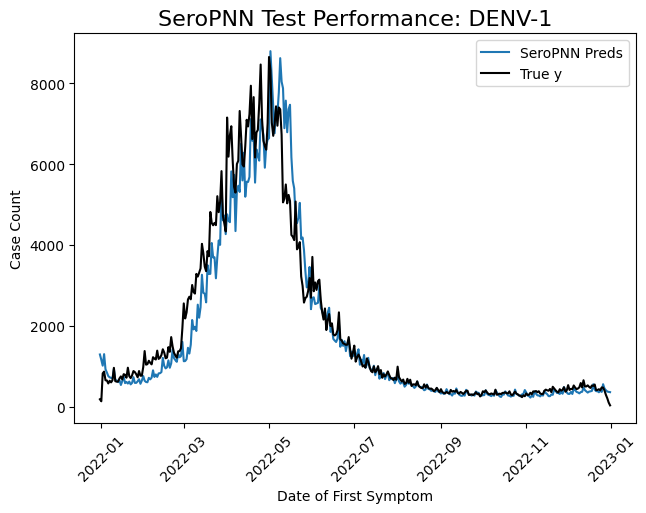

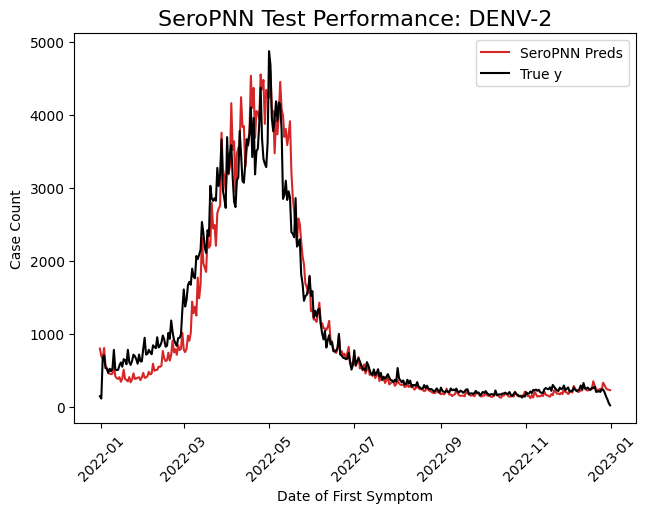

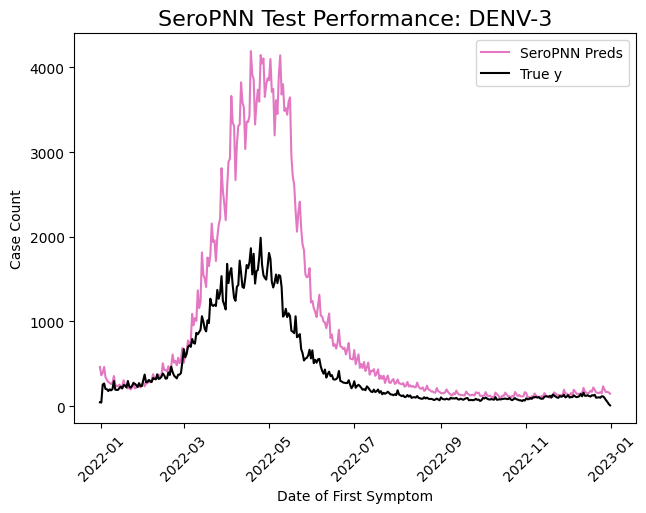

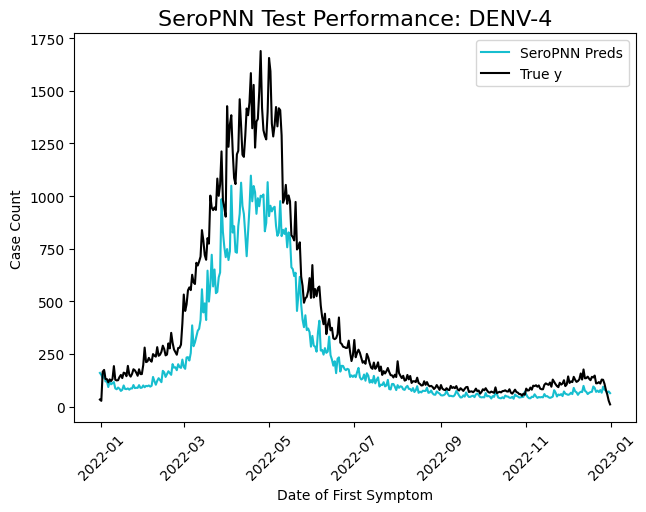

In [19]:
sero_pnn_test_samples, test_y_true = eval_sero_pnn(test_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_test_samples, test_sero_pnn_dataset, N, "SeroPNN Test Performance")

# crps = 0
# crps = sum([crps_ensemble(test_y_true[:,s,:,0], sero_pnn_test_samples[:,s,:]) for s in range(N)])
# print(f"CRPS: {crps}")